In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.common.exceptions import TimeoutException

import time

In [2]:
url = 'https://today.yougov.com/ratings/entertainment/popularity/all-time-actors-actresses/all'
path = "Path" # Path to webdriver executable

chrome_options = Options()
chrome_options.binary_location = r"C:\Program Files\Google\Chrome\Application\chrome.exe"

# Use only chrome_options, not executable_path
driver = webdriver.Chrome(options=chrome_options)

driver.get(url)


# Decline cookies settings
try:
    decline_button = WebDriverWait(driver, 10).until(
        EC.presence_of_element_located((By.ID, 'onetrust-reject-all-handler'))
    )

    decline_button.click()
except Exception as e:
    pass

# Scroll down to load more data
while True:
    # Scroll to the bottom of the page
    driver.find_element(By.TAG_NAME, 'body').send_keys(Keys.END)

    # Wait for a short interval to allow the content to load
    time.sleep(2)

    # Check if there are more actors loaded
    try:
        load_more_button = WebDriverWait(driver, 100).until(
            EC.element_to_be_clickable((By.CLASS_NAME, 'load-more-button'))
        )
        
        load_more_button.click()
    except TimeoutException:
        break

html = driver.page_source
driver.quit()

# Parse the HTML with BeautifulSoup
soup = BeautifulSoup(html, 'html.parser')

# Element containing the list of actors
actors_container = soup.find('div', class_='rankings-entities-list-container')

# Actor's list items
actor_items = actors_container.find_all('li', class_='ng-star-inserted')

# Create lists to store data
actor_names = []
popularity_percentages = []
fame_percentages = []

for actor_item in actor_items:
    # Extract the actor name
    actor_name = actor_item.find('img', class_='ng-star-inserted')['alt'] if actor_item.find('img', class_='ng-star-inserted') else None

    # Extract popularity percentage
    popularity_element = actor_item.find('span', class_='compact')
    popularity_percentage = popularity_element.text.split('%')[0] if popularity_element else None

    # Extract fame percentage
    fame_element = actor_item.find('span', class_='rankings-item-active')
    fame_percentage = fame_element.text.split('%')[0] if fame_element else None

    actor_names.append(actor_name)
    popularity_percentages.append(popularity_percentage)
    fame_percentages.append(fame_percentage)

data = {
    'Actor Name': actor_names,
    'Popularity (%)': popularity_percentages,
    'Fame (%)': fame_percentages
}

famous_actors = pd.DataFrame(data)

print(famous_actors)
famous_actors.to_csv('../Data/preprocessed_data/famous_actors_db.csv', index=False)


KeyboardInterrupt: 

### 1. Find relationship between fame and popularity

In [21]:
actors_db = pd.read_csv('../Data/preprocessed_data/actors_db.csv')
famous_actors_db = pd.read_csv('../Data/preprocessed_data/famous_actors_db.csv')

In [27]:
# Merge DataFrames on actor name
merged_data = pd.merge(actors_db, famous_actors_db, left_on='name', right_on='Actor Name', how='inner')

# Check for missing values
print(merged_data.isnull().sum())

# Calculate the correlation coefficient
correlation_coefficient = merged_data['Popularity (%)'].corr(merged_data['popularity'], method='pearson')
print(f'Correlation Coefficient: {correlation_coefficient}')

name                 0
gender               0
popularity           0
original_language    0
genre_ids            0
known_for            0
id                   0
Actor Name           0
Popularity (%)       0
Fame (%)             0
dtype: int64
Correlation Coefficient: 0.21853557565634227


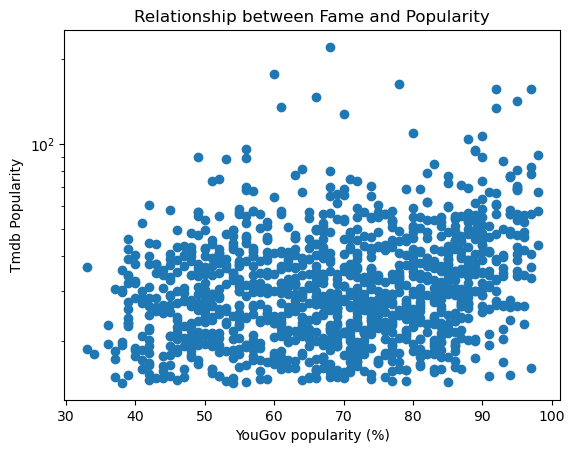

In [26]:
import matplotlib.pyplot as plt

# Not considered low
# Scatter plot
plt.scatter(merged_data['Popularity (%)'], merged_data['popularity'])
plt.xlabel('YouGov popularity (%)')
plt.ylabel('Tmdb Popularity')
plt.yscale('log')
plt.title('Relationship between Fame and Popularity')
plt.show()


Unfortunately, we cannot conclude a relationship between fame and popularity. We originally wanted to explore the relationship between fame and popularity for actors who have both features and determine if it's reasonable to extend the fame feature to other actors.  
But following the results we obtained, the correlation coefficient that is too weak (0.2) and the graph showing the relationship between both, we cannot conclude this latter.

## Movie trajectory for actors

In [36]:
# extract a json file and transform it into a dataframe
import requests
import pandas as pd
import json

tmdb_id2credit = json.load(open('../Data/tmdb_resources/tmdb_id2credit_full.json'))
id2credit_df = pd.DataFrame.from_dict(tmdb_id2credit, orient='index')
id2credit_df = id2credit_df.drop(columns='crew')

tmdb_id2credit_imdb_rating = json.load(open('../Data/tmdb_resources/tmdb_id2detail_imdb_rating.json'))
imdb_rating_df = pd.DataFrame.from_dict(tmdb_id2credit_imdb_rating, orient='index')

In [ ]:
columns_to_keep = ['id', 'original_title', 'release_date', 'original_language', 'genres', 'budget', 'revenue', 'imdb_average_rating']
imdb_rating_filtered_df = imdb_rating_df[columns_to_keep]
imdb_rating_filtered_df.reset_index(drop=True, inplace=True)

# Creating a dataframe with revenue that is different from 0
revenue_non_zero_df = imdb_rating_filtered_df[imdb_rating_filtered_df['revenue'] != 0]
print(f'The number of movies with revenue is {revenue_non_zero_df.shape[0]:,}')

# Creating a dataframe with imdb_average_rating different from NaN
rating_not_nan_df = imdb_rating_filtered_df.dropna(subset=['imdb_average_rating'])
print(f'The number of movies with imdb ratings is {rating_not_nan_df.shape[0]:,}')

# Display the updated DataFrame
display(imdb_rating_filtered_df)

The number of movies with revenue is 18,904
The number of movies with imdb ratings is 393,909


,id,original_title,release_date,original_language,genres,budget,revenue,imdb_average_rating
0,10016,Ghosts of Mars,2001-08-24,en,"[{'id': 28, 'name': 'Action'}, {'id': 27, 'nam...",28000000,14010832,4.9
1,263493,The Gangsters,1913-05-29,en,"[{'id': 35, 'name': 'Comedy'}]",0,0,6.8
2,50944,The Sorcerer's Apprentice,2002-04-12,en,"[{'id': 12, 'name': 'Adventure'}, {'id': 10751...",0,0,4.2
3,33592,White of the Eye,1987-06-19,en,"[{'id': 27, 'name': 'Horror'}, {'id': 53, 'nam...",0,0,6.1
4,43839,Alexander's Ragtime Band,1938-05-24,en,"[{'id': 18, 'name': 'Drama'}, {'id': 10402, 'n...",2000000,4000000,6.8
...,...,...,...,...,...,...,...,...
863077,1096279,Eva,2021-01-01,id,"[{'id': 99, 'name': 'Documentary'}]",0,0,NaN
863078,1001995,勾魂令,2018-02-02,zh,"[{'id': 27, 'name': 'Horror'}]",0,0,NaN
863079,823988,La Voix Humaine / L’Heure Espagnole,2021-03-26,en,[],0,0,NaN
863080,1022210,How Science Changed Our World,2010-12-23,en,"[{'id': 99, 'name': 'Documentary'}]",0,0,NaN


Cast preprocessing

In [ ]:
# Assuming 'id' is the common column between imdb_rating_filtered_df and id2credits
merged_df = pd.merge(imdb_rating_filtered_df, id2credit_df, on='id', how='inner')

# Filter rows with either revenue not equal to 0 or imdb_average_rating not NaN
merged_df_filtered = merged_df[(merged_df['revenue'] != 0) | (~merged_df['imdb_average_rating'].isna())]
merged_df_filtered.reset_index(drop=True, inplace=True)
merged_df_filtered = merged_df_filtered.rename(columns={'id': 'movie_id'})


# Now, you can use merged_df_filtered for further analysis or display the desired information
print(f'The number of movies with revenue or imdb ratings is {merged_df_filtered.shape[0]:,}')
display(merged_df_filtered)

The number of movies with revenue or imdb ratings is 396,556


,movie_id,original_title,release_date,original_language,genres,budget,revenue,imdb_average_rating,cast
0,10016,Ghosts of Mars,2001-08-24,en,"[{'id': 28, 'name': 'Action'}, {'id': 27, 'nam...",28000000,14010832,4.9,"[{'adult': False, 'gender': 1, 'id': 57395, 'k..."
1,263493,The Gangsters,1913-05-29,en,"[{'id': 35, 'name': 'Comedy'}]",0,0,6.8,"[{'adult': False, 'gender': 2, 'id': 1086663, ..."
2,50944,The Sorcerer's Apprentice,2002-04-12,en,"[{'id': 12, 'name': 'Adventure'}, {'id': 10751...",0,0,4.2,"[{'adult': False, 'gender': 1, 'id': 46948, 'k..."
3,33592,White of the Eye,1987-06-19,en,"[{'id': 27, 'name': 'Horror'}, {'id': 53, 'nam...",0,0,6.1,"[{'adult': False, 'gender': 2, 'id': 18181, 'k..."
4,43839,Alexander's Ragtime Band,1938-05-24,en,"[{'id': 18, 'name': 'Drama'}, {'id': 10402, 'n...",2000000,4000000,6.8,"[{'adult': False, 'gender': 2, 'id': 10922, 'k..."
...,...,...,...,...,...,...,...,...,...
396551,770135,Scandal in 97,2020-11-29,en,"[{'id': 53, 'name': 'Thriller'}]",0,0,4.9,"[{'adult': False, 'gender': 2, 'id': 1232652, ..."
396552,472471,Sniff!!!,2017-08-25,hi,"[{'id': 12, 'name': 'Adventure'}, {'id': 35, '...",0,0,5.3,"[{'adult': False, 'gender': 0, 'id': 1963881, ..."
396553,707790,マッハ’78,1978-02-25,ja,"[{'id': 28, 'name': 'Action'}]",0,0,6.1,"[{'adult': False, 'gender': 0, 'id': 2767640, ..."
396554,267899,El fuego inolvidable,2014-09-11,es,"[{'id': 18, 'name': 'Drama'}]",0,865,7.8,"[{'adult': False, 'gender': 2, 'id': 91251, 'k..."


Movie detail has revenue and imdb ratings   
Movie credits has movie-actor pair data  

**Objective**: Given an actor's id, return a plot with an x axis of the movies they appread in sorted by year and a y axis of the movies' ratings.


## Dividing datasets

Divide the dataset into 3 
Features:
- Career length
Averages:
- order
- budget
- revenue
- tmdb popularity of movies
- imdb ratings of movies
- tmb vote average

order, budget, revenue, career length, tmdb popularity of movies, tmdb vote average, number of movies, popularity of actor

In [52]:
# transform acting_in_2003_and_later.csv into a dataframe
import pandas as pd
actors_df = pd.read_csv('../Data/preprocessed_data/tmdb_acting_in_2003_and_later.csv')
display(actors_df)

,name,genre_mean_weighted,number_of_movies
0,Gary Oldman,['Crime'],57.0
1,Florence Pugh,['Mystery'],10.0
2,Jason Statham,['Science Fiction'],45.0
3,Jackie Chan,['Crime'],62.0
4,Scarlett Johansson,['Science Fiction'],51.0
...,...,...,...
8053,Alice Isaaz,['Romance'],6.0
8054,Peter Cullen,['Science Fiction'],18.0
8055,Mary Crosby,['Family'],3.0
8056,Daisuke Namikawa,['Mystery'],12.0


In [55]:
print(actors_df[actors_df["name"] == "Leonardo DiCaprio"]["genre_mean_weighted"])

78    ['Romance']
Name: genre_mean_weighted, dtype: object


In [56]:

# Creating full_actors_df DataFrame
full_actors_list = []

for _, row in merged_df_filtered.iterrows():
    for actor_info in row['cast']:
        actor_entry = {
            'gender': actor_info['gender'],
            'actor_id': actor_info['id'],
            'name': actor_info['name'],
            'popularity': actor_info['popularity'],
            'character': actor_info['character'],
            'order': actor_info['order'],
            'movie_id': row['movie_id'],
            'original_title': row['original_title'],
            'release_date': row['release_date'],
            'original_language': row['original_language'],
            'genres': row['genres'],
            'budget': row['budget'],
            'revenue': row['revenue'],
            'imdb_average_rating': row['imdb_average_rating']
        }
        full_actors_list.append(actor_entry)

full_actors_df = pd.DataFrame(full_actors_list)

# Display the resulting full_actors_df
display(full_actors_df)


NameError: name 'merged_df_filtered' is not defined

In [57]:
#display(full_actors_df)
#full_actors_df.to_csv('../Data/preprocessed_data/full_actors_db.csv', index=False)
full_actors_df = pd.read_csv('../Data/preprocessed_data/full_actors_db.csv')
# display(full_actors_df)

In [58]:
import pandas as pd
# remove rows where the imdb_average_rating is NaN
full_actors_df = full_actors_df.dropna(subset=['imdb_average_rating'])
# Filter full_actors_df to keep only the actors in actors_df
full_actors_df = full_actors_df[full_actors_df['name'].isin(actors_df['name'])]

full_actors_df.reset_index(drop=True, inplace=True)
full_actors_df.to_csv('../Data/preprocessed_data/full_actors_filtered_db.csv', index=False)
# full_actors_df = pd.read_csv('../Data/preprocessed_data/full_actors_filtered_db.csv')
display(full_actors_df)

# calculate the number of movies each actor has played in and add the column number_of_movies
number_of_movies = full_actors_df.groupby('name')['movie_id'].nunique()
number_of_movies_df = pd.DataFrame(number_of_movies)
number_of_movies_df.reset_index(inplace=True)
number_of_movies_df.rename(columns={'movie_id': 'number_of_movies'}, inplace=True)
display(number_of_movies_df)

,gender,actor_id,name,popularity,character,order,movie_id,original_title,release_date,original_language,genres,budget,revenue,imdb_average_rating
0,1,57395,Natasha Henstridge,49.626,Lt. Melanie Ballard,0,10016,Ghosts of Mars,2001-08-24,en,"[{'id': 28, 'name': 'Action'}, {'id': 27, 'nam...",28000000,14010832,4.9
1,2,9778,Ice Cube,24.423,James 'Desolation' Williams,1,10016,Ghosts of Mars,2001-08-24,en,"[{'id': 28, 'name': 'Action'}, {'id': 27, 'nam...",28000000,14010832,4.9
2,1,2230,Pam Grier,22.806,Commander Helena Braddock,2,10016,Ghosts of Mars,2001-08-24,en,"[{'id': 28, 'name': 'Action'}, {'id': 27, 'nam...",28000000,14010832,4.9
3,2,976,Jason Statham,199.055,Sgt. Jericho Butler,3,10016,Ghosts of Mars,2001-08-24,en,"[{'id': 28, 'name': 'Action'}, {'id': 27, 'nam...",28000000,14010832,4.9
4,1,20387,Clea DuVall,21.220,Bashira Kincaid,4,10016,Ghosts of Mars,2001-08-24,en,"[{'id': 28, 'name': 'Action'}, {'id': 27, 'nam...",28000000,14010832,4.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307595,1,8857,Debbie Reynolds,20.281,Self (archive footage),8,844511,Sœur Sourire : Qui a tué la voix de Dieu ?,2021-06-11,fr,"[{'id': 99, 'name': 'Documentary'}, {'id': 104...",0,0,7.1
307596,1,164094,Marin Ireland,15.430,Anna,0,589496,Megafauna,2010-06-04,en,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",0,0,6.7
307597,2,58769,Stephen Colbert,4.737,Self (archive footage),12,376261,Weiner,2016-05-20,en,"[{'id': 99, 'name': 'Documentary'}]",0,0,7.6
307598,2,33663,Donald Trump,18.380,Self (archive footage),16,376261,Weiner,2016-05-20,en,"[{'id': 99, 'name': 'Documentary'}]",0,0,7.6


,name,number_of_movies
0,"""Weird Al"" Yankovic",52
1,50 Cent,47
2,A Martinez,54
3,A.C. Peterson,65
4,A.J. Buckley,30
...,...,...
8051,Óscar Jaenada,40
8052,Özcan Deniz,13
8053,Úrsula Corberó,12
8054,Şükrü Özyıldız,9


In [59]:
# regroup the actors by name and concatenate all their other features so that we have arrays in each one of them
import numpy as np
# Group the actors by name and concatenate all their other features
grouped_actors_df = full_actors_df.groupby('name').agg({
    # get the first element of gender, since it is the same for all rows
    'gender': lambda x: x.iloc[0],
    'popularity': lambda x: list(x),
    'release_date': lambda x: list(x),
    'genres': lambda x: list(x),
    'budget': lambda x: list(x),
    'revenue': lambda x: list(x),
    'imdb_average_rating': lambda x: list(x),
    'order': lambda x: list(x)
})


grouped_actors_df['release_date'] = grouped_actors_df['release_date'].apply(
    lambda x: sorted([date for date in x if pd.notna(date) and date != ''] if isinstance(x, list) else []))
grouped_actors_df['career_length'] = grouped_actors_df['release_date'].apply(
    lambda x: int(x[-1][:4]) - int(x[0][:4]) if len(x) >= 2 and x[-1][:4] and x[0][:4] else 0)

#grouped_actors_df['career_length'] = grouped_actors_df['release_date'].apply(lambda x: int(x[-1][:4]) - int(x[0][:4]) if len(x) >= 2 and x[-1][:4] and x[0][:4] else 0)


# Add column number of movie from dataframe number_of_movies_df using the name as the key
grouped_actors_df = pd.merge(grouped_actors_df, number_of_movies_df, on='name', how='inner')
display(grouped_actors_df)
# divide the actors into 3 dataframes based on their career length
# group 1: career length < 20
# group 2: 20 <= career length < 40
# group 3: career length >= 40

# get the actors with career length < 20
group1_df = grouped_actors_df[grouped_actors_df['career_length'] < 20]
# get the actors with career length >= 20 and < 40
group2_df = grouped_actors_df[(grouped_actors_df['career_length'] >= 20) & (grouped_actors_df['career_length'] < 40)]
# get the actors with career length >= 40
group3_df = grouped_actors_df[grouped_actors_df['career_length'] >= 40]


,name,gender,popularity,release_date,genres,budget,revenue,imdb_average_rating,order,career_length,number_of_movies
0,"""Weird Al"" Yankovic",2,"[13.081, 13.081, 5.609, 10.655, 13.081, 10.655...","[1985-09-25, 1988-10-21, 1988-12-02, 1989-07-2...","[[{'id': 35, 'name': 'Comedy'}, {'id': 28, 'na...","[18000000, 3000000, 0, 0, 30000000, 0, 5000000...","[27000000, 343786, 0, 0, 51132598, 0, 6157157,...","[5.3, 5.7, 8.7, 8.3, 6.5, 7.3, 6.9, 7.6, 4.3, ...","[13, 16, 0, 0, 35, 2, 0, 11, 6, 0, 13, 0, 8, 3...",38,52
1,50 Cent,2,"[14.999, 11.633, 10.69, 14.999, 10.69, 14.999,...","[2003-04-15, 2003-04-22, 2003-08-03, 2004-08-3...","[[{'id': 18, 'name': 'Drama'}, {'id': 35, 'nam...","[40000000, 0, 0, 11000000, 0, 0, 10000000, 100...","[60040976, 0, 0, 0, 0, 2566717, 0, 0, 0, 79498...","[6.5, 5.4, 4.4, 4.6, 4.4, 5.6, 3.8, 4.4, 6.8, ...","[59, 1, 1, 0, 0, 2, 0, 0, 1, 4, 0, 1, 0, 0, 0,...",20,47
2,A Martinez,2,"[15.752, 11.636, 15.752, 11.636, 11.636, 11.63...","[1968-10-01, 1972-01-13, 1972-02-21, 1973-01-0...","[[{'id': 35, 'name': 'Comedy'}], [{'id': 18, '...","[20000000, 0, 500000, 0, 0, 0, 11800000, 0, 0,...","[15400000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[5.7, 6.2, 3.0, 6.8, 6.7, 2.1, 5.7, 7.2, 5.8, ...","[6, 6, 2, 11, 4, 1, 5, 0, 1, 3, 3, 7, 15, 5, 1...",54,54
3,A.C. Peterson,2,"[18.63, 18.63, 18.63, 18.63, 18.63, 7.26, 18.6...","[1984-12-26, 1985-07-28, 1986-11-29, 1987-09-2...","[[{'id': 18, 'name': 'Drama'}, {'id': 10749, '...","[11000000, 0, 3500000, 0, 6500000, 0, 61000000...","[4385312, 1733017, 44462, 4654288, 12633747, 0...","[6.1, 5.9, 6.7, 5.3, 7.1, 5.4, 7.1, 6.0, 5.3, ...","[55, 32, 8, 11, 12, 18, 10, 8, 4, 5, 13, 10, 2...",37,65
4,A.J. Buckley,2,"[14.75, 9.655, 14.75, 14.75, 9.655, 14.75, 14....","[1998-07-24, 1999-05-18, 1999-10-17, 2000-07-1...","[[{'id': 28, 'name': 'Action'}, {'id': 53, 'na...","[1000000, 0, 1000000, 15000000, 0, 1000000, 15...","[0, 0, 0, 5217498, 0, 464000, 17514980, 0, 0, ...","[4.6, 6.5, 5.8, 4.6, 3.7, 6.6, 5.6, 5.2, 5.3, ...","[1, 9, 4, 13, 5, 4, 11, 4, 9, 6, 1, 42, 7, 3, ...",20,30
...,...,...,...,...,...,...,...,...,...,...,...
8051,Óscar Jaenada,2,"[9.549, 9.549, 11.329, 9.549, 9.549, 11.329, 7...","[2001-01-05, 2003-09-12, 2003-09-26, 2004-08-2...","[[{'id': 18, 'name': 'Drama'}, {'id': 36, 'nam...","[40000000, 379000000, 0, 20000000, 25000000, 0...","[8638163, 1045713802, 0, 16863583, 23580000, 0...","[6.8, 6.6, 6.2, 4.9, 6.2, 6.1, 4.2, 6.0, 5.2, ...","[7, 12, 9, 11, 5, 6, 1, 0, 1, 0, 0, 0, 23, 0, ...",22,40
8052,Özcan Deniz,2,"[12.175, 12.583, 12.175, 12.175, 12.175, 12.58...","[2002-12-06, 2003-03-27, 2003-10-16, 2004-02-2...","[[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'na...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5000000]","[7.4, 4.9, 5.0, 3.6, 5.7, 6.2, 6.1, 5.2, 6.0, ...","[1, 0, 0, 0, 0, 1, 0, 0, 1, 2, 2, 5, 1]",15,13
8053,Úrsula Corberó,1,"[53.548, 27.525, 28.748, 53.548, 27.525, 53.54...","[2011-12-28, 2013-02-05, 2013-04-06, 2013-11-1...","[[{'id': 27, 'name': 'Horror'}], [{'id': 35, '...","[4362560, 0, 0, 869115, 0, 88000000, 0, 0, 0, ...","[0, 0, 0, 1018486, 0, 36964325, 0, 0, 850259, ...","[3.7, 4.5, 4.6, 6.6, 5.8, 5.4, 5.7, 3.8, 5.6, ...","[1, 1, 0, 7, 4, 3, 1, 0, 3, 0, 1, 2]",10,12
8054,Şükrü Özyıldız,2,"[28.837, 24.124, 28.837, 26.226, 28.837, 24.12...","[2013-09-13, 2015-02-06, 2016-01-20, 2016-10-2...","[[{'id': 18, 'name': 'Drama'}, {'id': 35, 'nam...","[0, 0, 0, 1705235, 0, 0, 0, 0, 0]","[0, 0, 0, 3501037, 0, 0, 0, 0, 0]","[7.1, 6.0, 4.9, 7.0, 6.2, 6.8, 5.3, 4.7, 5.3]","[5, 0, 1, 9, 3, 5, 1, 1, 1]",10,9


In [20]:
import ast

In [60]:
# Add column number of movie from dataframe number_of_movies_df using the name as the key
# grouped_actors_df = pd.merge(grouped_actors_df, number_of_movies_df, on='name', how='inner')
grouped_actors_df = pd.read_csv("../Data/preprocessed_data/grouped_actors_db.csv")
grouped_actors_df["budget"] = grouped_actors_df["budget"].apply(lambda x: ast.literal_eval(x))
grouped_actors_df["imdb_average_rating"] = grouped_actors_df["imdb_average_rating"].apply(lambda x: ast.literal_eval(x))
grouped_actors_df["revenue"] = grouped_actors_df["revenue"].apply(lambda x: ast.literal_eval(x))
grouped_actors_df["popularity"] = grouped_actors_df["popularity"].apply(lambda x: ast.literal_eval(x))
grouped_actors_df["order"] = grouped_actors_df["order"].apply(lambda x: ast.literal_eval(x))
grouped_actors_df["genres"] = grouped_actors_df["genres"].apply(lambda x: ast.literal_eval(x))
display(grouped_actors_df)
# divide the actors into 3 dataframes based on their career length
# group 1: career length < 20
# group 2: 20 <= career length < 40
# group 3: career length >= 40

# get the actors with career length < 20
group1_df = grouped_actors_df[grouped_actors_df['career_length'] < 20]
# get the actors with career length >= 20 and < 40
group2_df = grouped_actors_df[(grouped_actors_df['career_length'] >= 20) & (grouped_actors_df['career_length'] < 40)]
# get the actors with career length >= 40
group3_df = grouped_actors_df[grouped_actors_df['career_length'] >= 40]

,name,gender,popularity,release_date,genres,budget,revenue,imdb_average_rating,order,career_length,number_of_movies
0,"""Weird Al"" Yankovic",2,"[13.081, 13.081, 5.609, 10.655, 13.081, 10.655...","['1996-05-24', '1988-10-21', '2003-02-09', '19...","[[{'id': 35, 'name': 'Comedy'}, {'id': 28, 'na...","[18000000, 3000000, 0, 0, 30000000, 0, 5000000...","[27000000, 343786, 0, 0, 51132598, 0, 6157157,...","[5.3, 5.7, 8.7, 8.3, 6.5, 7.3, 6.9, 7.6, 4.3, ...","[13, 16, 0, 0, 35, 2, 0, 11, 6, 0, 13, 0, 8, 3...",38,52
1,50 Cent,2,"[14.999, 11.633, 10.69, 14.999, 10.69, 14.999,...","['2010-11-10', '2011-03-05', '2009-07-13', '20...","[[{'id': 18, 'name': 'Drama'}, {'id': 35, 'nam...","[40000000, 0, 0, 11000000, 0, 0, 10000000, 100...","[60040976, 0, 0, 0, 0, 2566717, 0, 0, 0, 79498...","[6.5, 5.4, 4.4, 4.6, 4.4, 5.6, 3.8, 4.4, 6.8, ...","[59, 1, 1, 0, 0, 2, 0, 0, 1, 4, 0, 1, 0, 0, 0,...",20,47
2,A Martinez,2,"[15.752, 11.636, 15.752, 11.636, 11.636, 11.63...","['1989-12-08', '1980-04-28', '2011-01-29', '20...","[[{'id': 35, 'name': 'Comedy'}], [{'id': 18, '...","[20000000, 0, 500000, 0, 0, 0, 11800000, 0, 0,...","[15400000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[5.7, 6.2, 3.0, 6.8, 6.7, 2.1, 5.7, 7.2, 5.8, ...","[6, 6, 2, 11, 4, 1, 5, 0, 1, 3, 3, 7, 15, 5, 1...",54,54
3,A.C. Peterson,2,"[18.63, 18.63, 18.63, 18.63, 18.63, 7.26, 18.6...","['1984-12-26', '1987-09-25', '2009-09-12', '19...","[[{'id': 18, 'name': 'Drama'}, {'id': 10749, '...","[11000000, 0, 3500000, 0, 6500000, 0, 61000000...","[4385312, 1733017, 44462, 4654288, 12633747, 0...","[6.1, 5.9, 6.7, 5.3, 7.1, 5.4, 7.1, 6.0, 5.3, ...","[55, 32, 8, 11, 12, 18, 10, 8, 4, 5, 13, 10, 2...",37,65
4,A.J. Buckley,2,"[14.75, 9.655, 14.75, 14.75, 9.655, 14.75, 14....","['2007-01-01', '2001-02-16', '2006-02-05', '20...","[[{'id': 28, 'name': 'Action'}, {'id': 53, 'na...","[1000000, 0, 1000000, 15000000, 0, 1000000, 15...","[0, 0, 0, 5217498, 0, 464000, 17514980, 0, 0, ...","[4.6, 6.5, 5.8, 4.6, 3.7, 6.6, 5.6, 5.2, 5.3, ...","[1, 9, 4, 13, 5, 4, 11, 4, 9, 6, 1, 42, 7, 3, ...",20,30
...,...,...,...,...,...,...,...,...,...,...,...
8051,Óscar Jaenada,2,"[9.549, 9.549, 11.329, 9.549, 9.549, 11.329, 7...","['2008-12-12', '2011-05-15', '2009-05-01', '20...","[[{'id': 18, 'name': 'Drama'}, {'id': 36, 'nam...","[40000000, 379000000, 0, 20000000, 25000000, 0...","[8638163, 1045713802, 0, 16863583, 23580000, 0...","[6.8, 6.6, 6.2, 4.9, 6.2, 6.1, 4.2, 6.0, 5.2, ...","[7, 12, 9, 11, 5, 6, 1, 0, 1, 0, 0, 0, 23, 0, ...",22,40
8052,Özcan Deniz,2,"[12.175, 12.583, 12.175, 12.175, 12.175, 12.58...","['2004-02-20', '2003-03-27', '2012-11-02', '20...","[[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'na...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5000000]","[7.4, 4.9, 5.0, 3.6, 5.7, 6.2, 6.1, 5.2, 6.0, ...","[1, 0, 0, 0, 0, 1, 0, 0, 1, 2, 2, 5, 1]",15,13
8053,Úrsula Corberó,1,"[53.548, 27.525, 28.748, 53.548, 27.525, 53.54...","['2011-12-28', '2015-04-24', '2017-01-17', '20...","[[{'id': 27, 'name': 'Horror'}], [{'id': 35, '...","[4362560, 0, 0, 869115, 0, 88000000, 0, 0, 0, ...","[0, 0, 0, 1018486, 0, 36964325, 0, 0, 850259, ...","[3.7, 4.5, 4.6, 6.6, 5.8, 5.4, 5.7, 3.8, 5.6, ...","[1, 1, 0, 7, 4, 3, 1, 0, 3, 0, 1, 2]",10,12
8054,Şükrü Özyıldız,2,"[28.837, 24.124, 28.837, 26.226, 28.837, 24.12...","['2016-10-28', '2015-02-06', '2023-07-14', '20...","[[{'id': 18, 'name': 'Drama'}, {'id': 35, 'nam...","[0, 0, 0, 1705235, 0, 0, 0, 0, 0]","[0, 0, 0, 3501037, 0, 0, 0, 0, 0]","[7.1, 6.0, 4.9, 7.0, 6.2, 6.8, 5.3, 4.7, 5.3]","[5, 0, 1, 9, 3, 5, 1, 1, 1]",10,9


In [61]:
group1_df.head()

,name,gender,popularity,release_date,genres,budget,revenue,imdb_average_rating,order,career_length,number_of_movies
7,Aaron Abrams,2,"[9.527, 9.39, 9.39, 9.39, 6.805, 9.39, 9.527, ...","['2008-09-07', '2011-11-25', '2004-09-10', '20...","[[{'id': 18, 'name': 'Drama'}], [{'id': 18, 'n...","[0, 0, 45000000, 40000000, 0, 40000000, 0, 0, ...","[0, 4965950, 129394835, 19643086, 0, 26800000,...","[7.0, 6.5, 6.1, 5.8, 5.8, 5.7, 5.5, 6.1, 6.2, ...","[47, 4, 19, 2, 3, 15, 10, 1, 0, 4, 22, 2, 3, 1...",17,32
10,Aaron Dean Eisenberg,2,"[15.968, 14.39]","['2011-08-01', '2019-04-29']","[[{'id': 27, 'name': 'Horror'}, {'id': 878, 'n...","[0, 0]","[0, 0]","[4.9, 5.4]","[0, 5]",8,2
11,Aaron Dessner,2,"[25.402, 3.056, 1.902, 3.056]","['2013-09-19', '2022-03-13', '2008-05-26', '20...","[[{'id': 99, 'name': 'Documentary'}, {'id': 10...","[0, 0, 0, 0]","[137460, 0, 0, 0]","[7.3, 9.3, 7.1, 8.4]","[2, 0, 1, 2]",14,4
14,Aaron Hill,2,"[24.45, 24.45, 24.45, 24.45, 24.45, 9.679, 11....","['2011-09-09', '2009-06-19', '2011-12-02', '20...","[[{'id': 27, 'name': 'Horror'}], [{'id': 878, ...","[3000000, 200000000, 2500000, 1000000, 2500000...","[533235, 836303693, 0, 0, 52395996, 0, 0, 0, 0...","[3.6, 6.0, 5.2, 4.0, 6.4, 5.6, 3.7, 5.2, 5.7, ...","[4, 22, 7, 14, 12, 2, 12, 17, 3, 1, 4]",8,11
15,Aaron Himelstein,2,"[3.828, 31.229, 31.229, 31.229, 3.548, 4.199, ...","['2006-04-25', '2006-11-17', '2002-07-26', '20...","[[{'id': 35, 'name': 'Comedy'}], [{'id': 18, '...","[0, 0, 63000000, 30000000, 0, 0, 0, 750000, 18...","[0, 2209322, 296938801, 47126295, 0, 0, 0, 0, ...","[4.5, 6.3, 6.2, 7.4, 4.7, 6.4, 4.9, 5.5, 4.9, ...","[5, 38, 13, 28, 12, 1, 0, 5, 14, 64, 7, 15, 12...",16,16


In [73]:
# code for group 1
group1_divided_df = group1_df.copy()

# calculate the mean in average and revenue and replace the Nan and 0 values with the mean
group1_divided_df['avg_revenue_0'] = group1_divided_df['revenue'].apply(lambda x: np.mean(x) if isinstance(x, list) else x)
group1_divided_df['avg_budget_0'] = group1_divided_df['budget'].apply(lambda x: np.mean(x) if isinstance(x, list) else x)
group1_divided_df['std_budget_0'] = group1_divided_df['budget'].apply(lambda x: np.std(x) if isinstance(x, list) else x)
group1_divided_df['avg_imdb_rating_0'] = group1_divided_df['imdb_average_rating'].apply(lambda x: np.mean(x) if isinstance(x, list) else x)
group1_divided_df['avg_order_0'] = group1_divided_df['order'].apply(lambda x: np.mean(x) if isinstance(x, list) else x)
group1_divided_df['std_order_0'] = group1_divided_df['order'].apply(lambda x: np.std(x) if isinstance(x, list) else x)
group1_divided_df['avg_popularity_0'] = group1_divided_df['popularity'].apply(lambda x: np.mean(x) if isinstance(x, list) else x)


In [74]:
# find the most frequent genre and genres diversity for movies, released during specified time interval (per actor)
def genres_stats_per_period(row, start_column, end_column):
    genres_counts = {}
    genres_per_actor = row["genres"]

    release_dates_per_actor = row['release_date']
    for genres_per_movie, release_date in zip(row["genres"], row["release_date"]):
        # start_column is missing for the group 1 because all its members belong to the same time period
        if start_column is None or row[start_column] <= release_date <= row[end_column]:
            for genre in ast.literal_eval(genres_per_movie):
                genres_counts[genre["name"]] = genres_counts.get(genre["name"], 0) + 1
    
    # genres diversity is a number of different genres an actor played in during the specified time period 
    n_genres = len(genres_counts)
    # find the most frequent genre for an actor during the time period
    if n_genres > 0:
        sorted_by_frequency = sorted(genres_counts.items(), key=lambda item: item[1])
        main_genre = sorted_by_frequency[-1][0]
        # if 2 genres has equal frequency return both 
        if n_genres > 1 and sorted_by_frequency[-1][1] == sorted_by_frequency[-2][1]:
            main_genre_extra = sorted_by_frequency[-2][0]
            main_genres = {main_genre, main_genre_extra}
            # remove documentary since it doesn't represent the theme of movie
            if "Documentary" in main_genres:
                main_genres.remove("Documentary")
            main_genres = list(main_genres)
        else:
            main_genres = [main_genre]

    else:
        main_genres = [None]
    return [n_genres, main_genres]


# calculate number of genres and main one for group 1
group1_divided_df[["n_genres", "main_genre"]] = group1_divided_df.apply(genres_stats_per_period, 
                                                                      start_column=None, end_column=None, 
                                                                      axis=1, result_type="expand")

group1_divided_df = group1_divided_df.drop(['release_date', 'budget', 'revenue', 'imdb_average_rating', 'order', 'popularity'], axis=1)

display(group1_divided_df)

,name,gender,genres,career_length,number_of_movies,avg_revenue_0,avg_budget_0,std_budget_0,avg_imdb_rating_0,avg_order_0,std_order_0,avg_popularity_0,n_genres,main_genre
7,Aaron Abrams,2,"[[{'id': 18, 'name': 'Drama'}], [{'id': 18, 'n...",17,32,9.727650e+06,7.656250e+06,1.903592e+07,6.059375,9.031250,14.092295,9.070594,14,[Drama]
10,Aaron Dean Eisenberg,2,"[[{'id': 27, 'name': 'Horror'}, {'id': 878, 'n...",8,2,0.000000e+00,0.000000e+00,0.000000e+00,5.150000,2.500000,2.500000,15.179000,4,"[Thriller, Crime]"
11,Aaron Dessner,2,"[[{'id': 99, 'name': 'Documentary'}, {'id': 10...",14,4,3.436500e+04,0.000000e+00,0.000000e+00,8.025000,1.250000,0.829156,8.354000,3,[Music]
14,Aaron Hill,2,"[[{'id': 27, 'name': 'Horror'}], [{'id': 878, ...",8,11,8.083936e+07,2.177273e+07,5.680163e+07,5.072727,8.909091,6.598272,18.326818,10,[Comedy]
15,Aaron Himelstein,2,"[[{'id': 35, 'name': 'Comedy'}], [{'id': 18, '...",16,16,1.541810e+08,4.114062e+07,9.366496e+07,5.918750,15.687500,15.994994,17.487375,13,[Comedy]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8050,Élodie Yung,1,"[[{'id': 53, 'name': 'Thriller'}, {'id': 80, '...",16,13,7.234982e+07,3.133075e+07,5.035786e+07,5.853846,8.615385,14.969397,22.092615,9,[Action]
8052,Özcan Deniz,2,"[[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'na...",15,13,3.846154e+05,0.000000e+00,0.000000e+00,5.153846,1.000000,1.358732,12.655308,7,[Drama]
8053,Úrsula Corberó,1,"[[{'id': 27, 'name': 'Horror'}], [{'id': 35, '...",10,12,3.236089e+06,7.769306e+06,2.422024e+07,5.425000,1.916667,1.977302,36.653333,11,[Comedy]
8054,Şükrü Özyıldız,2,"[[{'id': 18, 'name': 'Drama'}, {'id': 35, 'nam...",10,9,3.890041e+05,1.894706e+05,5.359037e+05,5.922222,2.888889,2.766644,27.499556,8,[Comedy]


In [75]:
from datetime import datetime, timedelta

# code for group 2
df = group2_df.copy()
# Convert release_date to a list of datetime objects
df['release_date'] = df['release_date'].apply(lambda x: [datetime.strptime(date, "%Y-%m-%d") for date in ast.literal_eval(x)])

# Calculate the time interval for each period
df['interval'] = (df['career_length'] // 2) * 365

# Initialize columns for date ranges
df['start_date_1'] = df.apply(lambda row: min(row['release_date']), axis=1)
df['end_date_1'] = df.apply(lambda row: min(row['release_date']) + timedelta(days=row['interval']), axis=1)
df['start_date_2'] = df.apply(lambda row: min(row['release_date']) + timedelta(days=row['interval']), axis=1)
df['end_date_2'] = df.apply(lambda row: max(row['release_date']), axis=1)

# Count the number of release dates within each time slot
df['count_interval_1'] = df.apply(lambda row: sum(start <= date <= end for date in row['release_date'] for start, end in [(row['start_date_1'], row['end_date_1'])]), axis=1)
df['count_interval_2'] = df.apply(lambda row: sum(start <= date <= end for date in row['release_date'] for start, end in [(row['start_date_2'], row['end_date_2'])]), axis=1)

# calculate the mean of the first count_interval_1 movies in revenue and replace the Nan and 0 values with the mean in these count_interval_1 movies
df['revenue'] = df['revenue'].apply(
    lambda x: [
        np.mean(x[:df['count_interval_1'].iloc[0]]) if (val == 0 or pd.isna(val)) else val for val in x[:df['count_interval_1'].iloc[0]]
    ] +
    [
        np.mean(x[df['count_interval_1'].iloc[0]:]) if (val == 0 or pd.isna(val)) else val for val in x[df['count_interval_1'].iloc[0]:]
    ] if isinstance(x, list) else x
)

df['budget'] = df['budget'].apply(
    lambda x: [
        np.mean(x[:df['count_interval_1'].iloc[0]]) if (val == 0 or pd.isna(val)) else val for val in x[:df['count_interval_1'].iloc[0]]
    ] +
    [
        np.mean(x[df['count_interval_1'].iloc[0]:]) if (val == 0 or pd.isna(val)) else val for val in x[df['count_interval_1'].iloc[0]:]
    ] if isinstance(x, list) else x
)


# Calculate the average budget, revenue, IMDb rating, popularity and order for each period
df['avg_budget_0'] = df.apply(lambda row: np.mean([budget for budget, date in zip(row['budget'], row['release_date']) if row['start_date_1'] <= date <= row['end_date_1']]), axis=1)
df['avg_budget_1'] = df.apply(lambda row: np.mean([budget for budget, date in zip(row['budget'], row['release_date']) if row['start_date_2'] <= date <= row['end_date_2']]), axis=1)
df['std_budget_0'] = df.apply(lambda row: np.std([budget for budget, date in zip(row['budget'], row['release_date']) if row['start_date_1'] <= date <= row['end_date_1']]), axis=1)
df['std_budget_1'] = df.apply(lambda row: np.std([budget for budget, date in zip(row['budget'], row['release_date']) if row['start_date_2'] <= date <= row['end_date_2']]), axis=1)
df['avg_revenue_0'] = df.apply(lambda row: np.mean([revenue for revenue, date in zip(row['revenue'], row['release_date']) if row['start_date_1'] <= date <= row['end_date_1']]), axis=1)
df['avg_revenue_1'] = df.apply(lambda row: np.mean([revenue for revenue, date in zip(row['revenue'], row['release_date']) if row['start_date_2'] <= date <= row['end_date_2']]), axis=1)
# replace values
df['avg_imdb_rating_0'] = df.apply(lambda row: np.mean([imdb_rating for imdb_rating, date in zip(row['imdb_average_rating'], row['release_date']) if row['start_date_1'] <= date <= row['end_date_1']]), axis=1)
df['avg_imdb_rating_1'] = df.apply(lambda row: np.mean([imdb_rating for imdb_rating, date in zip(row['imdb_average_rating'], row['release_date']) if row['start_date_2'] <= date <= row['end_date_2']]), axis=1)
df['avg_order_0'] = df.apply(lambda row: np.mean([order for order, date in zip(row['order'], row['release_date']) if row['start_date_1'] <= date <= row['end_date_1']]), axis=1)
df['avg_order_1'] = df.apply(lambda row: np.mean([order for order, date in zip(row['order'], row['release_date']) if row['start_date_2'] <= date <= row['end_date_2']]), axis=1)
df['std_order_0'] = df.apply(lambda row: np.std([order for order, date in zip(row['order'], row['release_date']) if row['start_date_1'] <= date <= row['end_date_1']]), axis=1)
df['std_order_1'] = df.apply(lambda row: np.std([order for order, date in zip(row['order'], row['release_date']) if row['start_date_2'] <= date <= row['end_date_2']]), axis=1)
df['avg_popularity_0'] = df.apply(lambda row: np.mean([popularity for popularity, date in zip(row['popularity'], row['release_date']) if row['start_date_1'] <= date <= row['end_date_1']]), axis=1)
df['avg_popularity_1'] = df.apply(lambda row: np.mean([popularity for popularity, date in zip(row['popularity'], row['release_date']) if row['start_date_2'] <= date <= row['end_date_2']]), axis=1)

In [76]:
# calculate number of genres and main one for the first time period
df[["n_genres_0", "main_genre_0"]] = df.apply(genres_stats_per_period, 
                                              start_column="start_date_1", 
                                              end_column="end_date_1", 
                                              axis=1, result_type="expand")
# calculate number of genres and main one for the second time period
df[["n_genres_1", "main_genre_1"]] = df.apply(genres_stats_per_period, 
                                              start_column="start_date_2", 
                                              end_column="end_date_2", 
                                              axis=1, result_type="expand")


# Drop unnecessary columns
df = df.drop(['release_date', 'budget', 'revenue', 'imdb_average_rating', 'order', 'popularity'], axis=1)

display(df)
group2_divided_df = df.copy()

,name,gender,genres,career_length,number_of_movies,interval,start_date_1,end_date_1,start_date_2,end_date_2,...,avg_order_0,avg_order_1,std_order_0,std_order_1,avg_popularity_0,avg_popularity_1,n_genres_0,main_genre_0,n_genres_1,main_genre_1
0,"""Weird Al"" Yankovic",2,"[[{'id': 35, 'name': 'Comedy'}, {'id': 28, 'na...",38,52,6935,1985-09-25,2004-09-20,2004-09-20,2023-03-11,...,7.937500,11.305556,10.899935,14.854516,8.860250,7.113139,9,[Comedy],12,[Comedy]
1,50 Cent,2,"[[{'id': 18, 'name': 'Drama'}, {'id': 35, 'nam...",20,47,3650,2003-04-15,2013-04-12,2013-04-12,2023-09-15,...,5.580645,8.125000,15.418410,10.734728,12.576419,13.711375,11,[Drama],9,[Action]
3,A.C. Peterson,2,"[[{'id': 18, 'name': 'Drama'}, {'id': 10749, '...",37,65,6570,1984-12-26,2002-12-22,2002-12-22,2021-11-25,...,15.516129,8.911765,10.213435,9.101931,11.268129,11.211382,13,[Drama],14,[Drama]
4,A.J. Buckley,2,"[[{'id': 28, 'name': 'Action'}, {'id': 53, 'na...",20,30,3650,1998-07-24,2008-07-21,2008-07-21,2018-04-20,...,7.565217,4.428571,8.801315,3.374575,12.783000,13.308571,15,[Drama],11,"[Drama, Comedy]"
5,A.J. Cook,1,"[[{'id': 35, 'name': 'Comedy'}], [{'id': 35, '...",22,20,4015,1997-01-29,2008-01-27,2008-01-27,2019-04-09,...,4.857143,4.166667,4.778780,5.335937,20.006143,17.360167,12,"[Drama, Horror]",7,[Drama]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8039,Zoe McLellan,1,"[[{'id': 18, 'name': 'Drama'}, {'id': 12, 'nam...",25,15,4380,1994-10-14,2006-10-11,2006-10-11,2019-11-22,...,11.666667,2.666667,11.333333,2.211083,12.229889,11.396500,9,[Drama],7,"[Drama, Thriller]"
8041,Zoe Saldaña,1,"[[{'id': 28, 'name': 'Action'}, {'id': 53, 'na...",23,62,4015,2000-05-12,2011-05-10,2011-05-10,2023-09-13,...,4.592593,8.600000,5.349000,17.543741,65.552185,65.861600,13,"[Drama, Comedy]",16,[Adventure]
8043,Zooey Deschanel,1,"[[{'id': 35, 'name': 'Comedy'}, {'id': 10749, ...",24,47,4380,1999-09-24,2011-09-21,2011-09-21,2023-10-12,...,3.171429,8.083333,3.652676,10.435982,44.876086,36.110167,15,[Comedy],12,[Music]
8044,Zosia Mamet,1,"[[{'id': 27, 'name': 'Horror'}], [{'id': 35, '...",29,26,5110,1994-08-04,2008-07-31,2008-07-31,2023-10-12,...,19.333333,5.173913,5.436502,8.239102,21.816000,22.699696,7,[Drama],12,[Comedy]


In [77]:
grouped_actors_df.head()

,name,gender,popularity,release_date,genres,budget,revenue,imdb_average_rating,order,career_length,number_of_movies
0,"""Weird Al"" Yankovic",2,"[13.081, 13.081, 5.609, 10.655, 13.081, 10.655...","['1996-05-24', '1988-10-21', '2003-02-09', '19...","[[{'id': 35, 'name': 'Comedy'}, {'id': 28, 'na...","[18000000, 3000000, 0, 0, 30000000, 0, 5000000...","[27000000, 343786, 0, 0, 51132598, 0, 6157157,...","[5.3, 5.7, 8.7, 8.3, 6.5, 7.3, 6.9, 7.6, 4.3, ...","[13, 16, 0, 0, 35, 2, 0, 11, 6, 0, 13, 0, 8, 3...",38,52
1,50 Cent,2,"[14.999, 11.633, 10.69, 14.999, 10.69, 14.999,...","['2010-11-10', '2011-03-05', '2009-07-13', '20...","[[{'id': 18, 'name': 'Drama'}, {'id': 35, 'nam...","[40000000, 0, 0, 11000000, 0, 0, 10000000, 100...","[60040976, 0, 0, 0, 0, 2566717, 0, 0, 0, 79498...","[6.5, 5.4, 4.4, 4.6, 4.4, 5.6, 3.8, 4.4, 6.8, ...","[59, 1, 1, 0, 0, 2, 0, 0, 1, 4, 0, 1, 0, 0, 0,...",20,47
2,A Martinez,2,"[15.752, 11.636, 15.752, 11.636, 11.636, 11.63...","['1989-12-08', '1980-04-28', '2011-01-29', '20...","[[{'id': 35, 'name': 'Comedy'}], [{'id': 18, '...","[20000000, 0, 500000, 0, 0, 0, 11800000, 0, 0,...","[15400000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[5.7, 6.2, 3.0, 6.8, 6.7, 2.1, 5.7, 7.2, 5.8, ...","[6, 6, 2, 11, 4, 1, 5, 0, 1, 3, 3, 7, 15, 5, 1...",54,54
3,A.C. Peterson,2,"[18.63, 18.63, 18.63, 18.63, 18.63, 7.26, 18.6...","['1984-12-26', '1987-09-25', '2009-09-12', '19...","[[{'id': 18, 'name': 'Drama'}, {'id': 10749, '...","[11000000, 0, 3500000, 0, 6500000, 0, 61000000...","[4385312, 1733017, 44462, 4654288, 12633747, 0...","[6.1, 5.9, 6.7, 5.3, 7.1, 5.4, 7.1, 6.0, 5.3, ...","[55, 32, 8, 11, 12, 18, 10, 8, 4, 5, 13, 10, 2...",37,65
4,A.J. Buckley,2,"[14.75, 9.655, 14.75, 14.75, 9.655, 14.75, 14....","['2007-01-01', '2001-02-16', '2006-02-05', '20...","[[{'id': 28, 'name': 'Action'}, {'id': 53, 'na...","[1000000, 0, 1000000, 15000000, 0, 1000000, 15...","[0, 0, 0, 5217498, 0, 464000, 17514980, 0, 0, ...","[4.6, 6.5, 5.8, 4.6, 3.7, 6.6, 5.6, 5.2, 5.3, ...","[1, 9, 4, 13, 5, 4, 11, 4, 9, 6, 1, 42, 7, 3, ...",20,30


In [78]:
from datetime import datetime, timedelta

df = group3_df.copy()
# Convert release_date to a list of datetime objects
df['release_date'] = df['release_date'].apply(lambda x: [datetime.strptime(date, "%Y-%m-%d") for date in ast.literal_eval(x)])

# Calculate the time interval for each period
df['interval'] = (df['career_length'] // 3) * 365

# Initialize columns for date ranges
df['start_date_1'] = df.apply(lambda row: min(row['release_date']), axis=1)
df['end_date_1'] = df.apply(lambda row: min(row['release_date']) + timedelta(days=row['interval']), axis=1)
df['start_date_2'] = df.apply(lambda row: min(row['release_date']) + timedelta(days=row['interval']), axis=1)
df['end_date_2'] = df.apply(lambda row: min(row['release_date']) + timedelta(days=row['interval'] * 2), axis=1)
df['start_date_3'] = df.apply(lambda row: min(row['release_date']) + timedelta(days=row['interval'] * 2 ), axis=1)
df['end_date_3'] = df.apply(lambda row: max(row['release_date']), axis=1)

# Count the number of release dates within each time slot
df['count_interval_1'] = df.apply(lambda row: sum(start <= date <= end for date in row['release_date'] for start, end in [(row['start_date_1'], row['end_date_1'])]), axis=1)
df['count_interval_2'] = df.apply(lambda row: sum(start <= date <= end for date in row['release_date'] for start, end in [(row['start_date_2'], row['end_date_2'])]), axis=1)
df['count_interval_3'] = df.apply(lambda row: sum(start <= date <= end for date in row['release_date'] for start, end in [(row['start_date_3'], row['end_date_3'])]), axis=1)

# Assuming df['count_interval_1'] and df['count_interval_2'] are available
df['revenue'] = df['revenue'].apply(
    lambda x: [
        np.mean(x[:df['count_interval_1'].iloc[0]]) if (val == 0 or pd.isna(val)) else val for val in x[:df['count_interval_1'].iloc[0]]
    ] +
    [
        np.mean(x[df['count_interval_1'].iloc[0]:df['count_interval_2'].iloc[0]]) if (val == 0 or pd.isna(val)) else val for val in x[df['count_interval_1'].iloc[0]:df['count_interval_2'].iloc[0]]
    ] +
    [
        np.mean(x[df['count_interval_2'].iloc[0]:]) if (val == 0 or pd.isna(val)) else val for val in x[df['count_interval_2'].iloc[0]:]
    ] if isinstance(x, list) else x
)
df['budget'] = df['budget'].apply(
    lambda x: [
        np.mean(x[:df['count_interval_1'].iloc[0]]) if (val == 0 or pd.isna(val)) else val for val in x[:df['count_interval_1'].iloc[0]]
    ] +
    [
        np.mean(x[df['count_interval_1'].iloc[0]:df['count_interval_2'].iloc[0]]) if (val == 0 or pd.isna(val)) else val for val in x[df['count_interval_1'].iloc[0]:df['count_interval_2'].iloc[0]]
    ] +
    [
        np.mean(x[df['count_interval_2'].iloc[0]:]) if (val == 0 or pd.isna(val)) else val for val in x[df['count_interval_2'].iloc[0]:]
    ] if isinstance(x, list) else x
)


# Calculate the average budget, revenue, IMDb rating, popularity and order for each period
df['avg_budget_0'] = df.apply(lambda row: np.mean([budget for budget, date in zip(row['budget'], row['release_date']) if row['start_date_1'] <= date <= row['end_date_1']]), axis=1)
df['avg_budget_1'] = df.apply(lambda row: np.mean([budget for budget, date in zip(row['budget'], row['release_date']) if row['start_date_2'] <= date <= row['end_date_2']]), axis=1)
df['avg_budget_2'] = df.apply(lambda row: np.mean([budget for budget, date in zip(row['budget'], row['release_date']) if row['start_date_3'] <= date <= row['end_date_3']]), axis=1)
df['std_budget_0'] = df.apply(lambda row: np.std([budget for budget, date in zip(row['budget'], row['release_date']) if row['start_date_1'] <= date <= row['end_date_1']]), axis=1)
df['std_budget_1'] = df.apply(lambda row: np.std([budget for budget, date in zip(row['budget'], row['release_date']) if row['start_date_2'] <= date <= row['end_date_2']]), axis=1)
df['std_budget_2'] = df.apply(lambda row: np.std([budget for budget, date in zip(row['budget'], row['release_date']) if row['start_date_3'] <= date <= row['end_date_3']]), axis=1)
df['avg_revenue_0'] = df.apply(lambda row: np.mean([revenue for revenue, date in zip(row['revenue'], row['release_date']) if row['start_date_1'] <= date <= row['end_date_1']]), axis=1)
df['avg_revenue_1'] = df.apply(lambda row: np.mean([revenue for revenue, date in zip(row['revenue'], row['release_date']) if row['start_date_2'] <= date <= row['end_date_2']]), axis=1)
df['avg_revenue_2'] = df.apply(lambda row: np.mean([revenue for revenue, date in zip(row['revenue'], row['release_date']) if row['start_date_3']<= date <= row['end_date_3']]), axis=1)
df['avg_imdb_rating_0'] = df.apply(lambda row: np.mean([imdb_rating for imdb_rating, date in zip(row['imdb_average_rating'], row['release_date']) if row['start_date_1'] <= date <= row['end_date_1']]), axis=1)
df['avg_imdb_rating_1'] = df.apply(lambda row: np.mean([imdb_rating for imdb_rating, date in zip(row['imdb_average_rating'], row['release_date']) if row['start_date_2'] <= date <= row['end_date_2']]), axis=1)
df['avg_imdb_rating_2'] = df.apply(lambda row: np.mean([imdb_rating for imdb_rating, date in zip(row['imdb_average_rating'], row['release_date']) if row['start_date_3']<= date <= row['end_date_3']]), axis=1)
df['avg_order_0'] = df.apply(lambda row: np.mean([order for order, date in zip(row['order'], row['release_date']) if row['start_date_1'] <= date <= row['end_date_1']]), axis=1)
df['avg_order_1'] = df.apply(lambda row: np.mean([order for order, date in zip(row['order'], row['release_date']) if row['start_date_2'] <= date <= row['end_date_2']]), axis=1)
df['avg_order_2'] = df.apply(lambda row: np.mean([order for order, date in zip(row['order'], row['release_date']) if row['start_date_3'] <= date <= row['end_date_3']]), axis=1)
df['std_order_0'] = df.apply(lambda row: np.std([order for order, date in zip(row['order'], row['release_date']) if row['start_date_1'] <= date <= row['end_date_1']]), axis=1)
df['std_order_1'] = df.apply(lambda row: np.std([order for order, date in zip(row['order'], row['release_date']) if row['start_date_2'] <= date <= row['end_date_2']]), axis=1)
df['std_order_2'] = df.apply(lambda row: np.std([order for order, date in zip(row['order'], row['release_date']) if row['start_date_3'] <= date <= row['end_date_3']]), axis=1)
df['avg_popularity_0'] = df.apply(lambda row: np.mean([popularity for popularity, date in zip(row['popularity'], row['release_date']) if row['start_date_1'] <= date <= row['end_date_1']]), axis=1)
df['avg_popularity_1'] = df.apply(lambda row: np.mean([popularity for popularity, date in zip(row['popularity'], row['release_date']) if row['start_date_2'] <= date <= row['end_date_2']]), axis=1)
df['avg_popularity_2'] = df.apply(lambda row: np.mean([popularity for popularity, date in zip(row['popularity'], row['release_date']) if row['start_date_3'] <= date <= row['end_date_3']]), axis=1)

c:\Users\1\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\1\Anaconda\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\1\Anaconda\lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\1\Anaconda\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
c:\Users\1\Anaconda\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [79]:
# calculate number of genres and main one for the each time period
df[["n_genres_0", "main_genre_0"]] = df.apply(genres_stats_per_period, 
                                              start_column="start_date_1", 
                                              end_column="end_date_1", 
                                              axis=1, result_type="expand")
df[["n_genres_1", "main_genre_1"]] = df.apply(genres_stats_per_period, 
                                              start_column="start_date_2", 
                                              end_column="end_date_2", 
                                              axis=1, result_type="expand")
df[["n_genres_2", "main_genre_2"]] = df.apply(genres_stats_per_period, 
                                              start_column="start_date_3", 
                                              end_column="end_date_3", 
                                              axis=1, result_type="expand")



# Drop unnecessary columns
df = df.drop(['release_date', 'budget', 'revenue', 'imdb_average_rating', 'order', 'popularity'], axis=1)
df = df.drop(['interval'], axis=1)

group3_divided_df = df.copy()
display(group3_divided_df)

,name,gender,genres,career_length,number_of_movies,start_date_1,end_date_1,start_date_2,end_date_2,start_date_3,...,std_order_2,avg_popularity_0,avg_popularity_1,avg_popularity_2,n_genres_0,main_genre_0,n_genres_1,main_genre_1,n_genres_2,main_genre_2
2,A Martinez,2,"[[{'id': 35, 'name': 'Comedy'}], [{'id': 18, '...",54,54,1968-10-01,1986-09-27,1986-09-27,2004-09-22,2004-09-22,...,3.323987,12.934750,12.394864,12.983600,10,[Drama],14,[Drama],10,[Drama]
6,Aamir Khan,2,"[[{'id': 28, 'name': 'Action'}, {'id': 12, 'na...",49,61,1973-02-18,1989-02-14,1989-02-14,2005-02-10,2005-02-10,...,5.474119,15.212750,18.546516,20.704615,4,[Drama],11,[Drama],13,[Drama]
31,Abby Dalton,1,"[[{'id': 12, 'name': 'Adventure'}], [{'id': 80...",51,15,1957-04-01,1974-03-28,1974-03-28,1991-03-24,1991-03-24,...,2.357023,8.622700,6.832000,13.248000,8,[Drama],5,"[Drama, Comedy]",4,"[Adventure, Horror]"
35,Abe Vigoda,2,"[[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'na...",43,44,1965-11-10,1979-11-07,1979-11-07,1993-11-03,1993-11-03,...,8.056891,15.844286,13.599154,14.722000,8,"[TV Movie, Drama]",14,[Comedy],12,[Comedy]
42,Adam Arkin,2,"[[{'id': 35, 'name': 'Comedy'}], [{'id': 10751...",52,48,1969-01-01,1985-12-28,1985-12-28,2002-12-24,2002-12-24,...,3.703452,14.309300,17.324913,17.235933,8,[Comedy],11,[Drama],10,[Drama]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7955,Yorgo Voyagis,2,"[[{'id': 18, 'name': 'Drama'}], [{'id': 53, 'n...",57,38,1964-12-14,1983-12-10,1983-12-10,2002-12-05,2002-12-05,...,19.141791,11.553000,11.282600,10.125571,9,[Drama],15,[Drama],4,[Drama]
7964,Yuen Wah,2,"[[{'id': 28, 'name': 'Action'}, {'id': 12, 'na...",61,152,1962-12-05,1982-11-30,1982-11-30,2002-11-25,2002-11-25,...,4.997298,13.755565,14.107212,13.824447,10,[Action],12,[Action],14,[Action]
7980,Yuko Tanaka,1,"[[{'id': 18, 'name': 'Drama'}], [{'id': 18, 'n...",42,36,1981-01-08,1995-01-05,1995-01-05,2009-01-01,2009-01-01,...,3.080551,19.200000,16.964500,18.901571,7,[Drama],5,[Drama],5,[Drama]
8046,Zoë Wanamaker,1,"[[{'id': 18, 'name': 'Drama'}], [], [{'id': 18...",46,36,1973-04-19,1988-04-15,1988-04-15,2003-04-12,2003-04-12,...,6.383267,21.906875,21.665500,22.918563,6,[Drama],9,[Drama],12,[Drama]


In [80]:
# save the dataframes into csv files 
group1_divided_df.to_csv('../Data/preprocessed_data/group1_divided_df.csv', index=True)
group2_divided_df.to_csv('../Data/preprocessed_data/group2_divided_df.csv', index=True)
group3_divided_df.to_csv('../Data/preprocessed_data/group3_divided_df.csv', index=True)


In [28]:
full_actors_filtered_df = pd.read_csv('../Data/preprocessed_data/full_actors_filtered_db.csv')
#display(full_actors_filtered_df)

# get the id of the actor named '50 Cent'
group1_df = pd.read_csv('../Data/preprocessed_data/group1_divided_df.csv')
#display(group1_df)

,gender,actor_id,name,popularity,character,order,movie_id,original_title,release_date,original_language,genres,budget,revenue,imdb_average_rating
0,1,57395,Natasha Henstridge,49.626,Lt. Melanie Ballard,0,10016,Ghosts of Mars,2001-08-24,en,"[{'id': 28, 'name': 'Action'}, {'id': 27, 'nam...",28000000,14010832,4.9
1,2,9778,Ice Cube,24.423,James 'Desolation' Williams,1,10016,Ghosts of Mars,2001-08-24,en,"[{'id': 28, 'name': 'Action'}, {'id': 27, 'nam...",28000000,14010832,4.9
2,1,2230,Pam Grier,22.806,Commander Helena Braddock,2,10016,Ghosts of Mars,2001-08-24,en,"[{'id': 28, 'name': 'Action'}, {'id': 27, 'nam...",28000000,14010832,4.9
3,2,976,Jason Statham,199.055,Sgt. Jericho Butler,3,10016,Ghosts of Mars,2001-08-24,en,"[{'id': 28, 'name': 'Action'}, {'id': 27, 'nam...",28000000,14010832,4.9
4,1,20387,Clea DuVall,21.220,Bashira Kincaid,4,10016,Ghosts of Mars,2001-08-24,en,"[{'id': 28, 'name': 'Action'}, {'id': 27, 'nam...",28000000,14010832,4.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307595,1,8857,Debbie Reynolds,20.281,Self (archive footage),8,844511,Sœur Sourire : Qui a tué la voix de Dieu ?,2021-06-11,fr,"[{'id': 99, 'name': 'Documentary'}, {'id': 104...",0,0,7.1
307596,1,164094,Marin Ireland,15.430,Anna,0,589496,Megafauna,2010-06-04,en,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",0,0,6.7
307597,2,58769,Stephen Colbert,4.737,Self (archive footage),12,376261,Weiner,2016-05-20,en,"[{'id': 99, 'name': 'Documentary'}]",0,0,7.6
307598,2,33663,Donald Trump,18.380,Self (archive footage),16,376261,Weiner,2016-05-20,en,"[{'id': 99, 'name': 'Documentary'}]",0,0,7.6


,Unnamed: 0,name,gender,career_length,avg_revenue_0,avg_budget_0,avg_imdb_rating_0,avg_order_0,avg_popularity_0,genre_mean_weighted
0,0,Aaron Abrams,2,17,9.727650e+06,7.656250e+06,6.059375,9.031250,9.070594,['Family']
1,1,Aaron Hill,2,8,8.083936e+07,2.177273e+07,5.072727,8.909091,18.326818,['Family']
2,2,Aaron Himelstein,2,16,1.541810e+08,4.114062e+07,5.918750,15.687500,17.487375,['Mystery']
3,3,Aaron Staton,2,11,1.424238e+07,5.625000e+06,5.537500,12.750000,10.733125,['Crime']
4,4,Aaron Tveit,2,14,2.948120e+07,7.647059e+06,6.500000,10.058824,20.939765,['TV Movie']
...,...,...,...,...,...,...,...,...,...,...
1431,1431,Zoe Lister-Jones,1,19,2.562862e+07,1.438636e+07,5.963636,7.318182,17.613136,['Science Fiction']
1432,1432,Zoë Kravitz,1,15,1.327133e+08,4.523514e+07,6.359459,5.486486,29.143324,['Mystery']
1433,1433,Élodie Yung,1,16,7.234982e+07,3.133075e+07,5.853846,8.615385,22.092615,['Science Fiction']
1434,1434,Úrsula Corberó,1,10,3.236089e+06,7.769306e+06,5.425000,1.916667,36.653333,['Documentary']


In [35]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

# Use name of actor
def plot_movies_ratings_2(actor_id):
    actor_movies_sorted = full_actors_filtered_df[full_actors_filtered_df['actor_id'] == actor_id].sort_values(by='release_date')
    actor_name = actor_movies_sorted['name'].values[0]
    # get dates of separation
    date_middle = group2_df[group2_df['name'] == actor_name]['start_date_2'].values[0]
    
    fig = px.scatter(actor_movies_sorted, x='release_date', y='imdb_average_rating',
                     hover_data=['original_title' , 'order'],
                     labels={'imdb_average_rating': 'IMDb Rating', 'release_date': 'Release Year', 'original_title': 'Movie name', 'order': 'Order'},
                     title=f'IMDb Ratings and Genres of Movies for Actor {actor_name}')
    
    rgba_light_yellow = (255, 255, 100, 0.5)  # light yellow
    rgba_light_orange = (255, 165, 0, 0.5)    # light orange
    rgba_light_red = (240, 128, 128, 0.5)      # light red

    fig.add_shape(
        go.layout.Shape(
            type="rect",
            x0=actor_movies_sorted['release_date'].min(),
            x1=date_middle,
            y0=0,
            y1=11,
            fillcolor=f"rgba{rgba_light_yellow}",
            opacity=0.5,
            layer="below",
            line_width=0,
        )
    )

    fig.add_shape(
        go.layout.Shape(
            type="rect",
            x0=date_middle,
            x1=actor_movies_sorted['release_date'].max(),
            y0=0,
            y1=11,
            fillcolor=f"rgba{rgba_light_orange}",
            opacity=0.5,
            layer="below",
            line_width=0,
        )
    )


    # Set specific colors for the 'order' column
    fig.update_traces(marker=dict(color=actor_movies_sorted['order'].map({
        0: 'red', 1: 'red',
        2: 'yellowgreen', 3: 'yellowgreen', 4: 'yellowgreen', 5: 'yellowgreen',
        # Add more mappings for other orders as needed
    })))

    fig.show()


In [34]:
# Use name of actor
def plot_movies_ratings_1(actor_id):
    actor_movies_sorted = full_actors_filtered_df[full_actors_filtered_df['actor_id'] == actor_id].sort_values(by='release_date')
    actor_name = actor_movies_sorted['name'].values[0]
    # get dates of separation
    
    fig = px.scatter(actor_movies_sorted, x='release_date', y='imdb_average_rating',
                     hover_data=['original_title' , 'order'],
                     labels={'imdb_average_rating': 'IMDb Rating', 'release_date': 'Release Year', 'original_title': 'Movie name', 'order': 'Order'},
                     title=f'IMDb Ratings and Genres of Movies for Actor {actor_name}')
    
    rgba_light_yellow = (255, 255, 100, 0.5)  # light yellow
    rgba_light_orange = (255, 165, 0, 0.5)    # light orange
    rgba_light_red = (240, 128, 128, 0.5)      # light red

    fig.add_shape(
        go.layout.Shape(
            type="rect",
            x0=actor_movies_sorted['release_date'].min(),
            x1=actor_movies_sorted['release_date'].max(),
            y0=0,
            y1=11,
            fillcolor=f"rgba{rgba_light_yellow}",
            opacity=0.5,
            layer="below",
            line_width=0,
        )
    )

    # Set specific colors for the 'order' column
    fig.update_traces(marker=dict(color=actor_movies_sorted['order'].map({
        0: 'red', 1: 'red',
        2: 'yellowgreen', 3: 'yellowgreen', 4: 'yellowgreen', 5: 'yellowgreen',
        # Add more mappings for other orders as needed
    })))

    fig.show()


In [33]:
def plot_movies_ratings_3(actor_id):
    actor_movies_sorted = full_actors_filtered_df[full_actors_filtered_df['actor_id'] == actor_id].sort_values(by='release_date')
    actor_name = actor_movies_sorted['name'].values[0]
    # get dates of separation
    date_middle_1 = group3_df[group3_df['name'] == actor_name]['start_date_2'].values[0]
    date_middle_2 = group3_df[group3_df['name'] == actor_name]['start_date_3'].values[0]
    
    fig = px.scatter(actor_movies_sorted, x='release_date', y='imdb_average_rating',
                     hover_data=['original_title' , 'order'],
                     labels={'imdb_average_rating': 'IMDb Rating', 'release_date': 'Release Year', 'original_title': 'Movie name', 'order': 'Order'},
                     title=f'IMDb Ratings and Genres of Movies for Actor {actor_name}')
    
    rgba_light_yellow = (255, 255, 100, 0.5)  # light yellow
    rgba_light_orange = (255, 165, 0, 0.5)    # light orange
    rgba_light_red = (240, 128, 128, 0.5)      # light red

    fig.add_shape(
        go.layout.Shape(
            type="rect",
            x0=actor_movies_sorted['release_date'].min(),
            x1=date_middle_1,
            y0=0,
            y1=11,
            fillcolor=f"rgba{rgba_light_yellow}",
            opacity=0.5,
            layer="below",
            line_width=0,
        )
    )

    fig.add_shape(
        go.layout.Shape(
            type="rect",
            x0=date_middle_1,
            x1=date_middle_2,
            y0=0,
            y1=11,
            fillcolor=f"rgba{rgba_light_orange}",
            opacity=0.5,
            layer="below",
            line_width=0,
        )
    )

    fig.add_shape(
        go.layout.Shape(
            type="rect",
            x0=date_middle_2,
            x1=actor_movies_sorted['release_date'].max(),
            y0=0,
            y1=11,
            fillcolor=f"rgba{rgba_light_red}",
            opacity=0.5,
            layer="below",
            line_width=0,
        )
    )


    # Set specific colors for the 'order' column
    fig.update_traces(marker=dict(color=actor_movies_sorted['order'].map({
        0: 'red', 1: 'red',
        2: 'yellowgreen', 3: 'yellowgreen', 4: 'yellowgreen', 5: 'yellowgreen',
        # Add more mappings for other orders as needed
    })))

    fig.show()


In [32]:
id_1 = full_actors_filtered_df[full_actors_filtered_df['name'] == 'Zoe Lister-Jones']['actor_id'].iloc[0]
id_2 = full_actors_filtered_df[full_actors_filtered_df['name'] == '50 Cent']['actor_id'].iloc[0]
id_3 = full_actors_filtered_df[full_actors_filtered_df['name'] == 'Jackie Chan']['actor_id'].iloc[0]

plot_movies_ratings_1(id_1)
plot_movies_ratings_2(id_2)
plot_movies_ratings_3(id_3)